In [12]:
#!pip install pycuda
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule

import cupy as cp
import numpy as np


In [13]:
# CUDA kernel
modd = SourceModule("""
__global__ void vec_add(const double* A, const double* B, double* C)
{
    uint index = blockIdx.x * blockDim.x + threadIdx.x;
    C[index] = A[index] + B[index];
}
  """)

In [14]:
# Set up tests.
import math
import time

number_of_tests = 100
vector_sizes = [2**10, 2**12, 2**15, 2**16, 2**18]
numThreadsPerBlock = 1024

value_type = float

test_results_kernel = []
test_results_cupy = []
test_results_numpy = []

f_kernel_times = []
f_cupy_times = []
f_numpy_times = []

In [15]:
for vector_size in vector_sizes:

  kernel_times = np.zeros(number_of_tests)
  cupy_times = np.zeros(number_of_tests)
  numpy_times = np.zeros(number_of_tests)

  numBlocks = math.ceil(vector_size/numThreadsPerBlock)

  for k in range(number_of_tests):

    a = np.random.randn(vector_size)
    a = a.astype(value_type)

    b = np.random.randn(vector_size)
    b = b.astype(value_type)

    a_gpu = cuda.mem_alloc(a.size * a.dtype.itemsize)
    cuda.memcpy_htod(a_gpu, a)

    b_gpu = cuda.mem_alloc(b.size * b.dtype.itemsize)
    cuda.memcpy_htod(b_gpu, b)

    c = np.zeros(vector_size)
    c = c.astype(value_type)
    c_gpu = cuda.mem_alloc(c.size * c.dtype.itemsize)


    # Call the CUDA kernel.

    vec_add_kernel = modd.get_function("vec_add")
    start = time.time()
    vec_add_kernel(a_gpu, b_gpu, c_gpu, np.int32(vector_size), block=(numThreadsPerBlock, 1, 1), grid=(numBlocks, 1, 1))
    kernel_times[k] = time.time() - start

    # Copy the result back to the host.

    cuda.memcpy_dtoh(c, c_gpu)


    a_gpu.free()
    b_gpu.free()
    c_gpu.free()

    # Do same calculation in CuPy.
    a_cp = cp.asarray(a)
    b_cp = cp.asarray(b)

    start = time.time()
    c_cupy = cp.add(a_cp, b_cp)
    cupy_times[k] = time.time() - start
    c_cupy = cp.asnumpy(c_cupy)


    # Do same calculation in CPU.
    start = time.time()
    c_numpy = np.add(a, b)
    numpy_times[k] = time.time() - start

    # Verify the results
    test_results_kernel.append(np.allclose(c_numpy,c, 0.001,0.001))
    test_results_cupy.append(np.allclose(c_numpy,c_cupy, 0.001,0.001))



  f_kernel_times.append(1000*np.mean(kernel_times))
  f_cupy_times.append(1000*np.mean(cupy_times))
  f_numpy_times.append(1000*np.mean(numpy_times))




/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: module in out-of-thread context could not be cleaned up
  globals().clear()


In [16]:
print("All kernel tests passed succesfully:", all(test_results_kernel))
print("All CuPy tests passed succesfully:", all(test_results_cupy))


All kernel tests passed succesfully: True
All CuPy tests passed succesfully: True


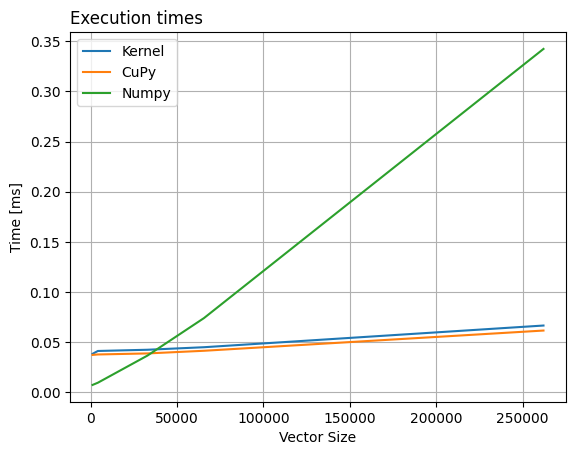

In [17]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.plot(vector_sizes, f_kernel_times, label='Kernel')
plt.plot(vector_sizes, f_cupy_times, label='CuPy')
plt.plot(vector_sizes, f_numpy_times, label='Numpy')


plt.grid()
plt.legend()
plt.title("Execution times", loc = 'left')
plt.xlabel("Vector Size")
plt.ylabel("Time [ms]")
plt.show()
